In [110]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
def get_model(path):
  return load_model(path)

In [113]:
Window=30
def get_data(predday,series):
  # fixed input size to model, last 30 day
    Predday = predday

    # To split the data into 90:10
    Trainsplit = 0.9

    cut = int(series.shape[0]*Trainsplit)

    # train
    closetrain = series[:cut]
    # test
    closetest = series[cut:-(Window+Predday)]
    # forecast for future 7 days
    closeforecast = series[-(Window+Predday):]

    return closetrain,closetest,closeforecast

In [114]:
def windowed_dataset(series, window_size,predday, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-predday], tf.squeeze(w[-predday:])))
    return ds.batch(batch_size).prefetch(3)

In [115]:
def future_predicted(testbatches,window_size,predday):
  x,y = next(iter(testbatches))
  output = model.predict(x)

  time=list(range(1,window_size+1))
  time2=list(range(window_size+1,window_size+predday+1))
  plt.plot(time,x[0])
  plt.plot(time2,output[0])
  plt.legend(['Actual Values','Predicted Values'])
  plt.title('Prediction for {} Days'.format(predday))

In [116]:
def visualplotloss(dataset,model,z,predday):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(z-1,(z-1)+predday))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

In [117]:
# using JD as its not as stable
df=web.DataReader('AAPL',data_source='yahoo',start='04-01-2003',end='07-15-2020')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-04-01,1.022143,1.005000,1.014286,1.011429,38585400.0,0.875591
2003-04-02,1.049286,1.019286,1.025714,1.042857,42842800.0,0.902799
2003-04-03,1.050000,1.025000,1.040000,1.032857,36428000.0,0.894142
2003-04-04,1.047857,1.027857,1.037143,1.029286,36505000.0,0.891050
2003-04-07,1.067857,1.029286,1.060714,1.035000,49215600.0,0.895997


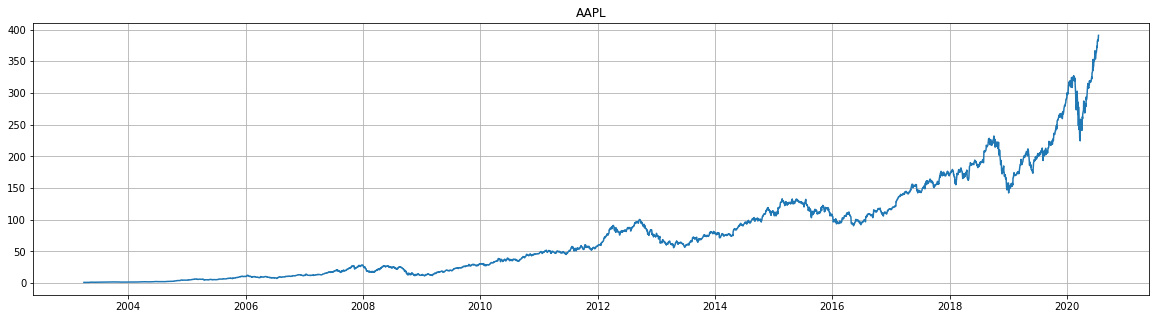

In [118]:
plt.figure(figsize=(20,5))
plt.plot(df.Close)
plt.title("AAPL")
plt.grid()

In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing valueŝ
ser = df.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [120]:
int(series.shape[0]*0.9)

3917

In [121]:
closetrain,closetest,closeforecast=get_data(7,series)

In [122]:
window_size=31
predday=7
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [123]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

In [124]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model1_pred_7days(1).h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 4

In [125]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
122/122 [==============================] - 6s 46ms/step - loss: 3.3692e-05 - mean_squared_error: 6.7384e-05 - val_loss: 1.8058e-04 - val_mean_squared_error: 3.6115e-04
Epoch 2/10
122/122 [==============================] - 4s 36ms/step - loss: 1.4355e-05 - mean_squared_error: 2.8711e-05 - val_loss: 2.8905e-04 - val_mean_squared_error: 5.7809e-04
Epoch 3/10
122/122 [==============================] - 4s 36ms/step - loss: 1.3273e-05 - mean_squared_error: 2.6546e-05 - val_loss: 2.0359e-04 - val_mean_squared_error: 4.0718e-04
Epoch 4/10
122/122 [==============================] - 4s 36ms/step - loss: 1.4137e-05 - mean_squared_error: 2.8275e-05 - val_loss: 1.8747e-04 - val_mean_squared_error: 3.7493e-04
Epoch 5/10
122/122 [==============================] - 4s 36ms/step - loss: 1.4995e-05 - mean_squared_error: 2.9991e-05 - val_loss: 2.0895e-04 - val_mean_squared_error: 4.1791e-04
Epoch 6/10
122/122 [==============================] - 4s 36ms/step - loss: 1.5357e-05 - mean_squared_erro

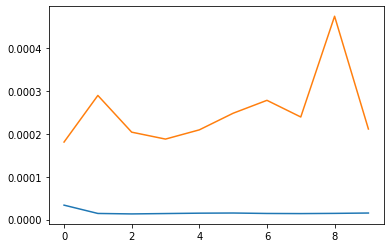

In [126]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [127]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

(8, 7)

In [128]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

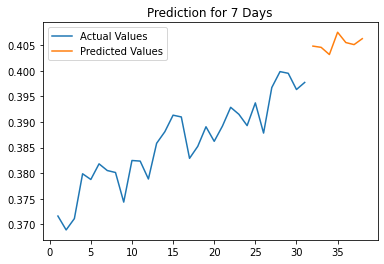

In [129]:
future_predicted(testbatches,window_size,predday)

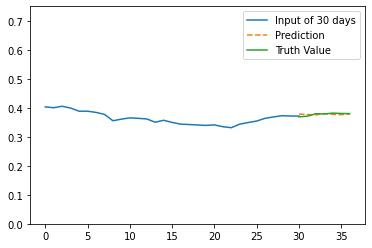

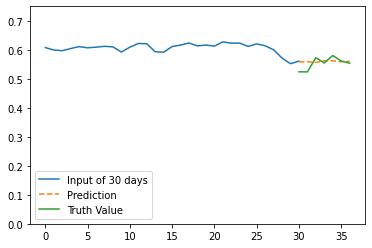

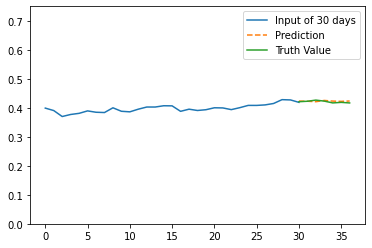

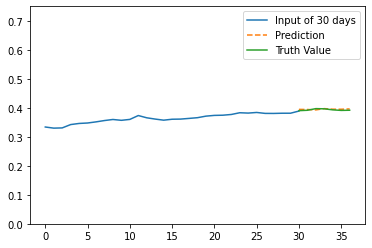

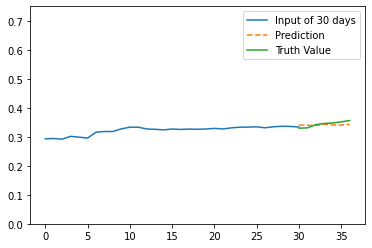

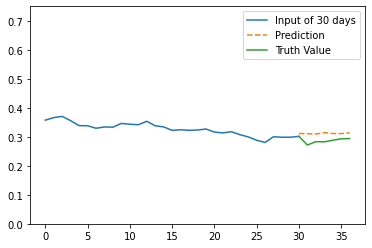

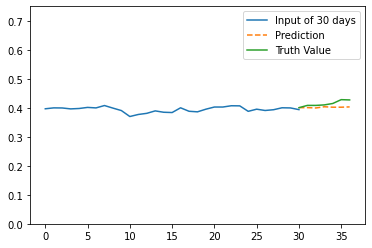

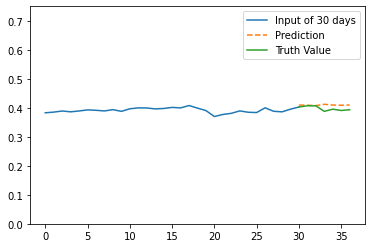

In [130]:
visualplotloss(testbatches,model,window_size,predday)

In [131]:
model.evaluate(testbatches)

46/46 [==============================] - 0s 11ms/step - loss: 2.1092e-04 - mean_squared_error: 4.2185e-04


[0.000210923288250342, 0.000421846576500684]

**Model 2**

In [132]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model2_pred_14days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 14)                9

In [133]:
closetrain,closetest,closeforecast=get_data(14,series)

In [134]:
window_size=62
predday=14
trainbatches =  windowed_dataset(closetrain,62,14)
testbatches =  windowed_dataset(closetest,62,14,batch_size=8)

In [135]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
121/121 [==============================] - 9s 71ms/step - loss: 5.8858e-05 - mean_squared_error: 1.1772e-04 - val_loss: 4.0842e-04 - val_mean_squared_error: 8.1683e-04
Epoch 2/10
121/121 [==============================] - 7s 59ms/step - loss: 3.2456e-05 - mean_squared_error: 6.4912e-05 - val_loss: 4.1842e-04 - val_mean_squared_error: 8.3683e-04
Epoch 3/10
121/121 [==============================] - 7s 60ms/step - loss: 2.5721e-05 - mean_squared_error: 5.1442e-05 - val_loss: 3.6253e-04 - val_mean_squared_error: 7.2505e-04
Epoch 4/10
121/121 [==============================] - 7s 60ms/step - loss: 3.0950e-05 - mean_squared_error: 6.1899e-05 - val_loss: 3.6690e-04 - val_mean_squared_error: 7.3379e-04
Epoch 5/10
121/121 [==============================] - 7s 60ms/step - loss: 3.1385e-05 - mean_squared_error: 6.2771e-05 - val_loss: 4.5865e-04 - val_mean_squared_error: 9.1730e-04
Epoch 6/10
121/121 [==============================] - 7s 60ms/step - loss: 2.7896e-05 - mean_squared_erro

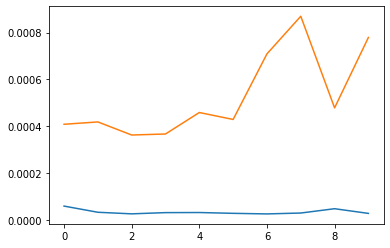

In [136]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [137]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

(8, 14)

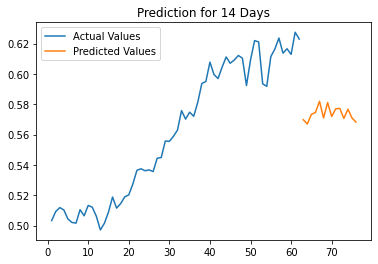

In [138]:
future_predicted(testbatches,window_size,predday)

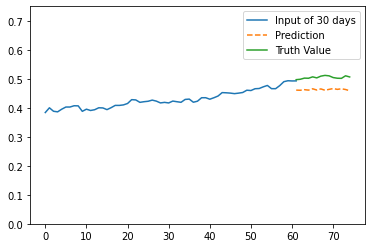

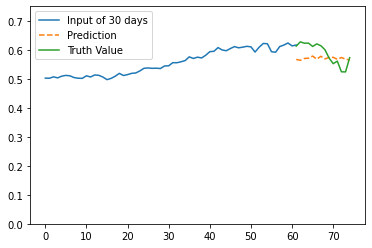

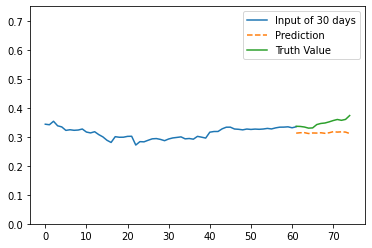

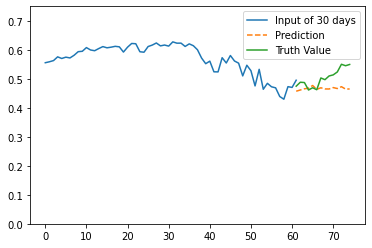

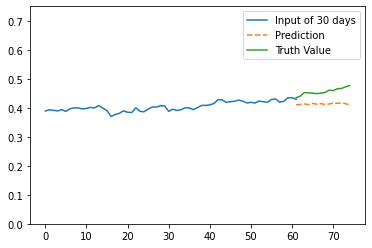

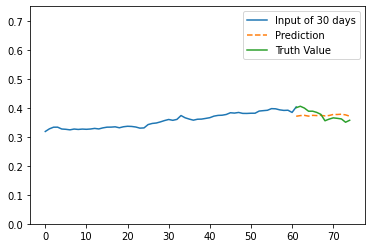

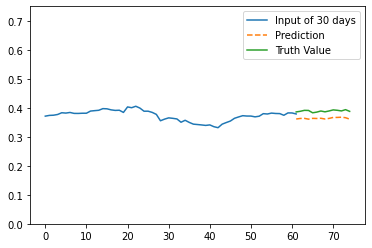

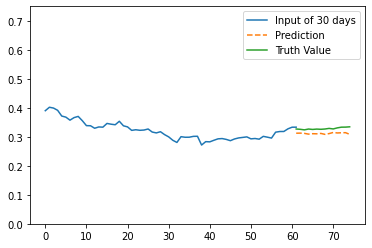

In [139]:
visualplotloss(testbatches,model,window_size,predday)

**Model 3**

In [140]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model_3_Pred21_Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1

In [141]:
closetrain,closetest,closeforecast=get_data(21,series)

In [142]:
window_size=90
predday=21
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [143]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
119/119 [==============================] - 11s 90ms/step - loss: 1.5127e-04 - mean_squared_error: 1.5127e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
119/119 [==============================] - 9s 80ms/step - loss: 7.4002e-05 - mean_squared_error: 7.4002e-05 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/10
119/119 [==============================] - 9s 80ms/step - loss: 8.0353e-05 - mean_squared_error: 8.0353e-05 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/10
119/119 [==============================] - 10s 80ms/step - loss: 8.1730e-05 - mean_squared_error: 8.1730e-05 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
119/119 [==============================] - 9s 79ms/step - loss: 7.1820e-05 - mean_squared_error: 7.1820e-05 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/10
119/119 [==============================] - 9s 79ms/step - loss: 7.1443e-05 - mean_squared_error: 7.1443e-05 - val_loss: 0.0011 - val

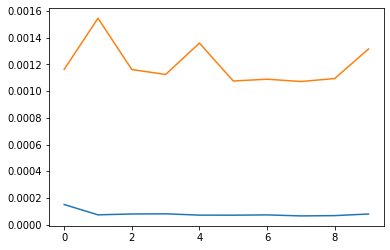

In [144]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

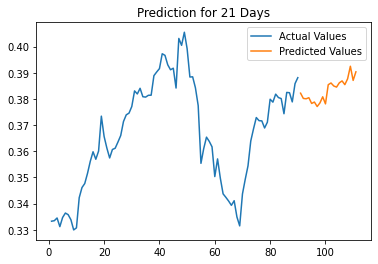

In [145]:
future_predicted(testbatches,window_size,predday)

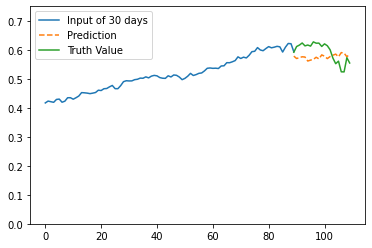

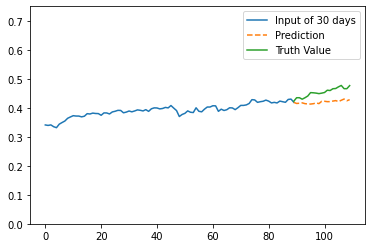

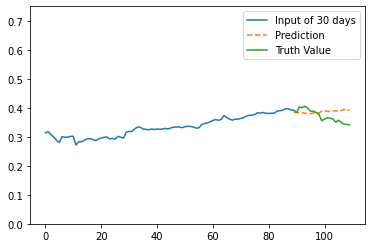

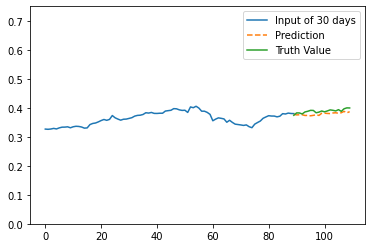

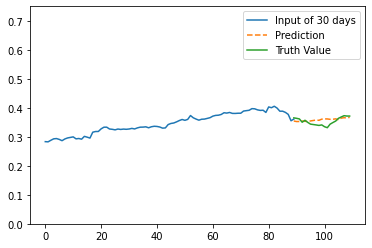

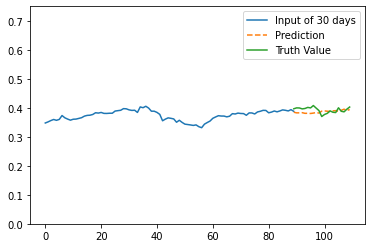

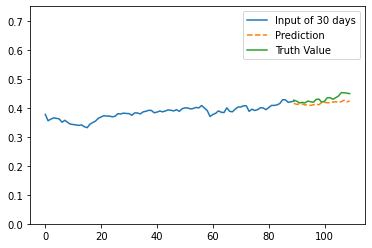

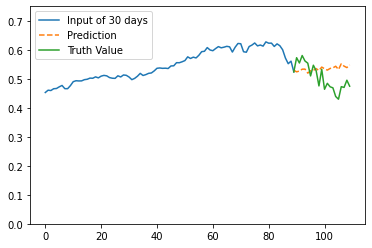

In [146]:
visualplotloss(testbatches,model,window_size,predday)

**Model 4**

In [147]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model_4_Pred28_Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1

In [148]:
closetrain,closetest,closeforecast=get_data(28,series)

In [149]:
window_size=128
predday=28
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [150]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
118/118 [==============================] - 14s 118ms/step - loss: 8.3895e-05 - mean_squared_error: 1.6779e-04 - val_loss: 8.6890e-04 - val_mean_squared_error: 0.0017
Epoch 2/10
118/118 [==============================] - 12s 105ms/step - loss: 5.5931e-05 - mean_squared_error: 1.1186e-04 - val_loss: 8.6667e-04 - val_mean_squared_error: 0.0017
Epoch 3/10
118/118 [==============================] - 12s 103ms/step - loss: 5.7406e-05 - mean_squared_error: 1.1481e-04 - val_loss: 8.5687e-04 - val_mean_squared_error: 0.0017
Epoch 4/10
118/118 [==============================] - 12s 102ms/step - loss: 5.0006e-05 - mean_squared_error: 1.0001e-04 - val_loss: 8.7572e-04 - val_mean_squared_error: 0.0018
Epoch 5/10
118/118 [==============================] - 12s 102ms/step - loss: 4.8954e-05 - mean_squared_error: 9.7907e-05 - val_loss: 9.1958e-04 - val_mean_squared_error: 0.0018
Epoch 6/10
118/118 [==============================] - 12s 100ms/step - loss: 4.8939e-05 - mean_squared_error: 9.787

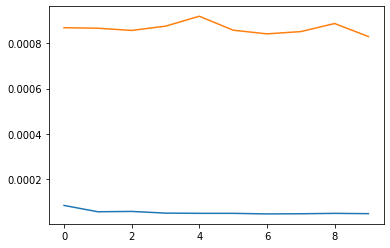

In [151]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

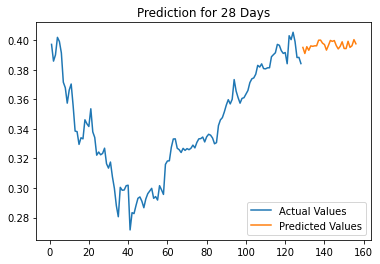

In [152]:
future_predicted(testbatches,window_size,predday)

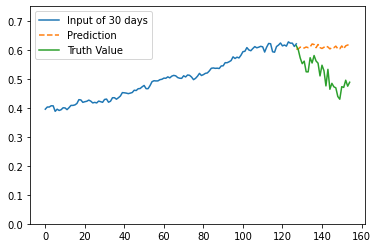

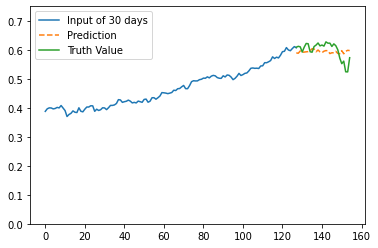

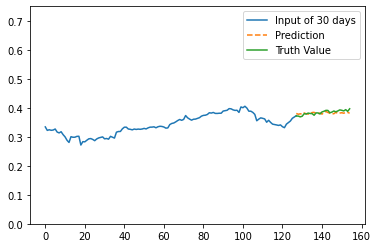

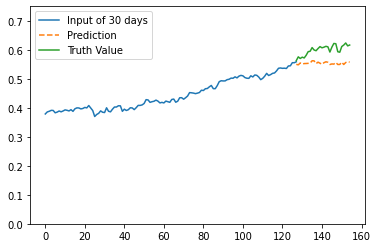

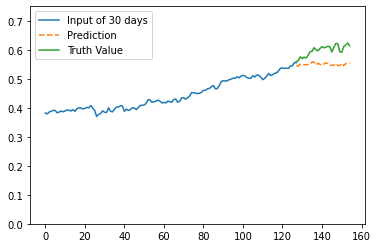

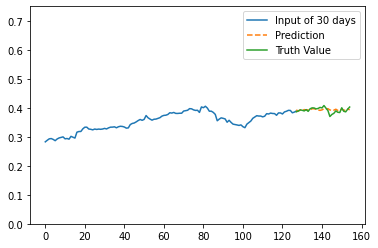

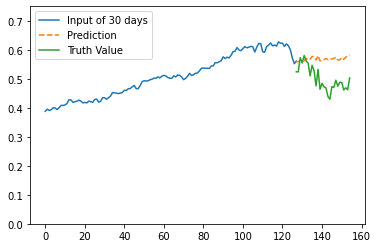

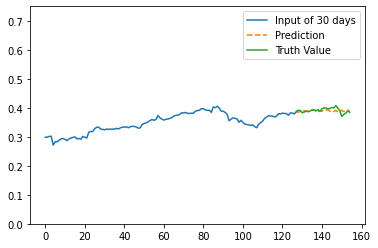

In [153]:
visualplotloss(testbatches,model,window_size,predday)

**Model 5**

In [154]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model5_Pred_35Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                2

In [155]:
closetrain,closetest,closeforecast=get_data(35,series)

In [156]:
window_size=150
predday=35
trainbatches =  windowed_dataset(closetrain,150,35)
testbatches =  windowed_dataset(closetest,150,35,batch_size=8)

In [157]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
117/117 [==============================] - 15s 129ms/step - loss: 7.1740e-05 - mean_squared_error: 1.4348e-04 - val_loss: 8.1417e-04 - val_mean_squared_error: 0.0016
Epoch 2/10
117/117 [==============================] - 13s 111ms/step - loss: 5.4463e-05 - mean_squared_error: 1.0893e-04 - val_loss: 9.0406e-04 - val_mean_squared_error: 0.0018
Epoch 3/10
117/117 [==============================] - 13s 110ms/step - loss: 5.2198e-05 - mean_squared_error: 1.0440e-04 - val_loss: 8.3805e-04 - val_mean_squared_error: 0.0017
Epoch 4/10
117/117 [==============================] - 13s 111ms/step - loss: 5.2542e-05 - mean_squared_error: 1.0508e-04 - val_loss: 8.8818e-04 - val_mean_squared_error: 0.0018
Epoch 5/10
117/117 [==============================] - 13s 107ms/step - loss: 5.5818e-05 - mean_squared_error: 1.1164e-04 - val_loss: 8.1792e-04 - val_mean_squared_error: 0.0016
Epoch 6/10
117/117 [==============================] - 12s 106ms/step - loss: 5.4385e-05 - mean_squared_error: 1.087

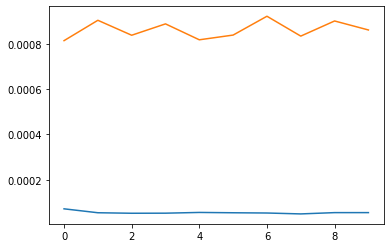

In [158]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

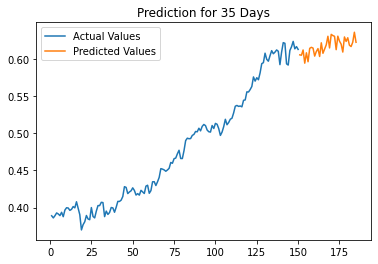

In [159]:
future_predicted(testbatches,window_size,predday)

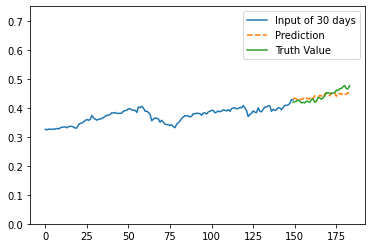

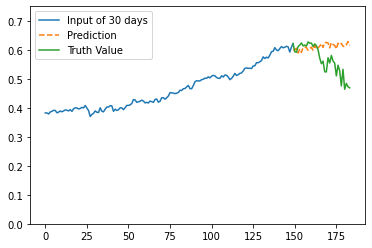

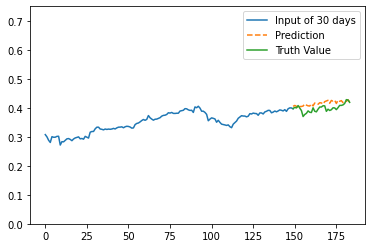

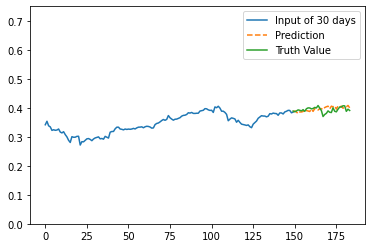

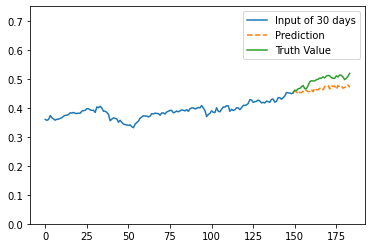

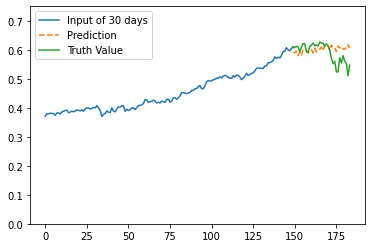

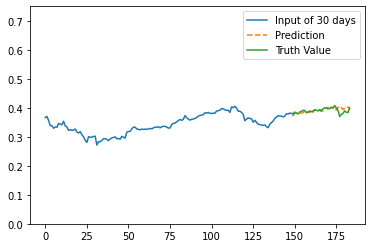

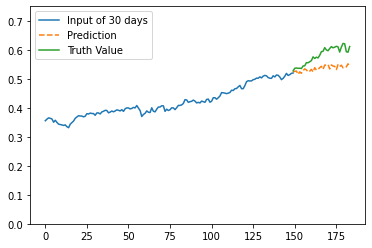

In [160]:
visualplotloss(testbatches,model,window_size,predday)